# 間違えやすいクラスを決めるための予備実験

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
import time
from random import *

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
def randints_nodup(k):
    ns = []
    while (len(ns) < k):
        n = randint(0, 9)
        if not n in ns:
            ns.append(n)
    return list(ns)

In [3]:
# entropy labelling
def tsallis_label(q, probas, s_cls):
    elements = np.power(probas, q - 1)
    # thrshld in tsallis entropy model
    ts_thrshld = np.sum(np.power(probas, q))
    if q < 1:
        labels = [s_cls[i] for i, e in enumerate(elements) if e <= ts_thrshld]
    else:
        labels = [s_cls[i] for i, e in enumerate(elements) if e >= ts_thrshld]
    return labels

In [4]:
def flip_label(pair, label):
    p_list = list(pair)
    flipped = [c for c in p_list if (c != label)]
    return flipped[0]

In [5]:
def flip_cond():
    r = random()
    if r <= 0.25:
        return True
    else:
        return False

#### ラベルづけからその正解率の評価まで行う関数

In [6]:
# labelling and evaluating them
def tsallis_ncls_eval(q, classes_num, orig_A, lim_A):
    s_cls = randints_nodup(classes_num)
    s_cls.sort()
    print(s_cls)
    
    # confusing pairs
    conf_pairs = [{0, 9}, {1, 7}, {3, 8}, {4, 6}]
    
    # extracting samples of the chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]
    # flip some labels
#     flip_flags = [True if c_pair < set(s_cls) else False for c_pair in conf_pairs]
    
#     for i, label in enumerate(trn_labels):
#         for j, flag in enumerate(flip_flags):
#             if (flag and flip_cond() and label in conf_pairs[j]):
#                 trn_labels[i] = flip_label(conf_pairs[j], label)
    
    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_proba = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])
    
    count = [[] for i in range(10)]
    # 間違え方の癖をみるため
    for i, pred in enumerate(a1_model.predict(test_imgs)):
        if (pred != test_labels[i]): 
#             print(f"predicted {pred} for {test_labels[i]}")
            count[test_labels[i]].append(pred)
    return s_cls, a1_proba[:4], count

## MNIST

In [7]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

Using TensorFlow backend.


### labels evaluation

In [8]:
for classes_num in range(10, 11):
    print(f"{classes_num} classes")
    orig_A1, lim_A1 = 2000, 2000
    q = 0.99
    s_cls, probas, count = tsallis_ncls_eval(q, classes_num, orig_A1, lim_A1)

10 classes
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [9]:
import collections

In [10]:
c_list = []
for i in range(10):
    c_list.append(collections.Counter(count[i]).most_common())
    print(f"for {i}: {collections.Counter(count[i]).most_common()}")

for 0: [(8, 16), (6, 16), (5, 15), (2, 14), (9, 8), (7, 6), (3, 3), (4, 2)]
for 1: [(8, 18), (2, 7), (3, 6), (6, 4), (4, 4), (9, 2), (0, 2), (5, 1)]
for 2: [(8, 47), (3, 26), (6, 20), (9, 18), (1, 16), (7, 13), (0, 13), (4, 9), (5, 6)]
for 3: [(5, 79), (2, 32), (8, 27), (7, 21), (9, 12), (1, 8), (6, 7), (0, 7), (4, 5)]
for 4: [(9, 79), (8, 31), (6, 17), (7, 9), (3, 7), (0, 6), (5, 5), (2, 3), (1, 1)]
for 5: [(3, 64), (8, 62), (4, 35), (6, 23), (9, 16), (0, 14), (7, 13), (2, 6), (1, 4)]
for 6: [(2, 26), (5, 23), (0, 22), (4, 13), (8, 9), (9, 6), (1, 4), (3, 3)]
for 7: [(9, 62), (2, 28), (1, 14), (3, 11), (4, 8), (5, 6), (8, 6), (0, 3), (6, 1)]
for 8: [(5, 85), (9, 41), (4, 34), (7, 33), (3, 28), (1, 27), (6, 22), (0, 20), (2, 15)]
for 9: [(7, 85), (4, 59), (3, 34), (8, 31), (5, 28), (0, 15), (1, 9), (2, 5)]


#### 簡単のため，今回の実験では間違いやすいラベルtop2を選んでflip対象に設定する

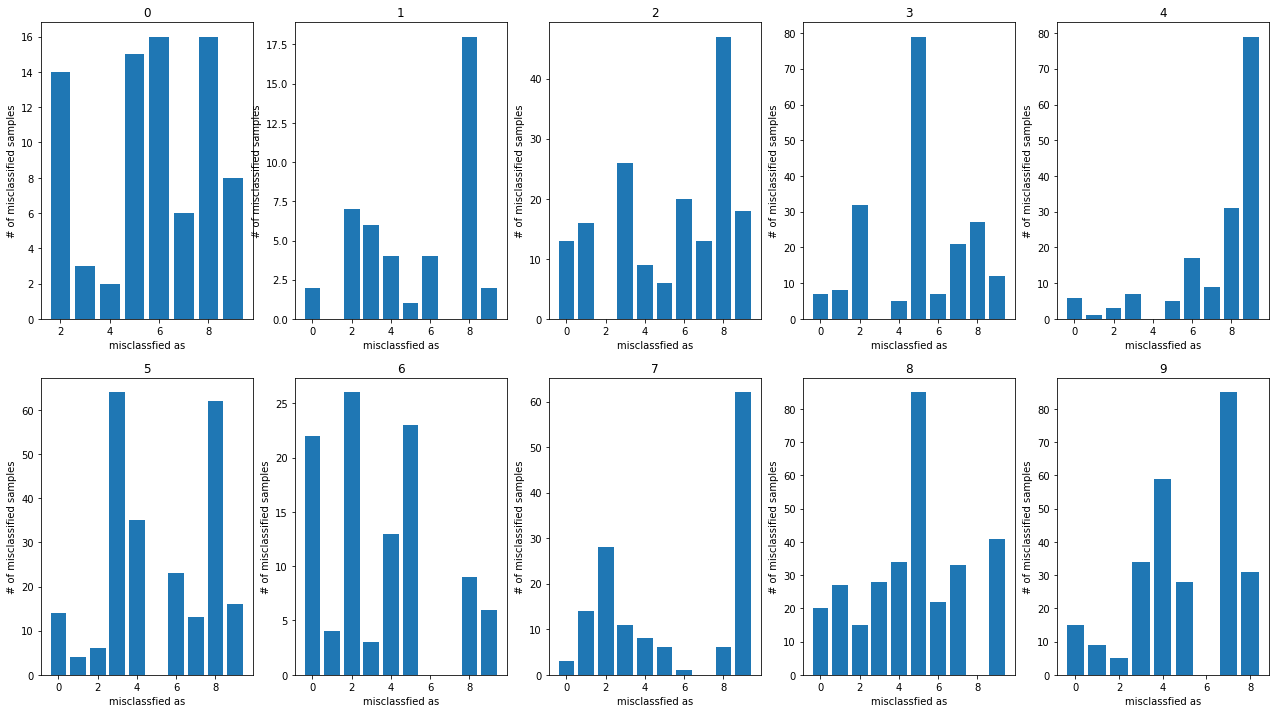

In [11]:
fig = plt.figure(figsize = (22, 12))
for i in range(10):
    x = [e[0] for e in sorted(c_list[i], key = lambda x: x[0])]
    y = [e[1] for e in sorted(c_list[i], key = lambda x: x[0])]
    fig.add_subplot(2, 5, i + 1)
    plt.bar(x, y)
    plt.xlabel("misclassfied as")
    plt.ylabel("# of misclassified samples")
    plt.title(i)
# plt.show()
plt.savefig("LR-misclassification-habits.pdf")